# Geopricing with atoti
In this notebook we will explore a pricing use case that combines machine learning algorithms and atoti.  

Imagine our retailer has many shops spread across France. The idea behind this notebook is to group the shops based on its price index and geographical characteristics to its competitors.  
Price index is a measurement of where a retailer is positioned compared to one or multiple of its competitors.   
Through the clustering, we will be able to apply different pricing strategies on each cluster based on its competition.  

We shall obtain the clustering of the shops via machine learning.  
For the machine learning, we will need a set of input features for each retail shops:
- Number of competitors per distance range (1km, 5km, 10km etc)
- Price Index per shop against its competitors  

We will see how we can generate these input values for the machine learning with atoti.  
Not only so, we will also make use of output from the machine learning to perform the below simulations:
- Pricing simulations around clusters to obtain the optimised price index against its neighbouring competitors
- Selling price simulation by clusters and retail shops to align the pricing within the cluster

### Dependencies
Assuming atoti is already installed, let's start by installing the additional libraries required for this notebook to work.

In [1]:
import sys

!conda install --yes --prefix {sys.prefix} folium scipy scikit-learn matplotlib seaborn

Solving environment: done

## Package Plan ##

  environment location: /home/jbe/.conda/envs/atoti-release

  added / updated specs:
    - folium
    - matplotlib
    - scikit-learn
    - scipy
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scipy-1.5.2                |   py37hb14ef9d_0        18.5 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        18.5 MB

The following packages will be UPDATED:

  scipy                                1.5.1-py37ha3d9a3c_0 --> 1.5.2-py37hb14ef9d_0



scipy-1.5.2          | 18.5 MB   | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [2]:
import atoti as tt
import pandas as pd

Welcome to atoti 0.4.2!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


## Data Preparation and exploration with atoti

Let's start by loading our data into atoti stores.

In [3]:
session = tt.create_session()

In [4]:
#  We used pandas to read the selling price here as we will be using it again for price optimisation in the later section.
product_sales_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/product_pricing.csv"
)

productSales = session.read_pandas(
    product_sales_df,
    keys=["ProductId", "ShopId"],
    store_name="ProductSales",
    types={"ProductId": tt.types.INT, "ShopId": tt.types.INT},
)
productSales.head()

The store has been sampled because there are more than 10000 lines in the files to load. Call Session.load_all_data() to trigger the full load of the data.


SellingPrice  PurchasePrice  Quantity
ProductId ShopId                                       
4096.0    1.0             1.92          1.632    6804.0
          2.0             2.07          1.841    9710.0
          3.0             1.82          1.492    5596.0
          4.0             1.82          1.661   10006.0
          5.0             2.02          1.814    6471.0

Due to the amount of data in this store, the store is sampled by default. We will proceed to load all the data only after we are done modeling the cube.

We will also require the competitors' product pricing against our shops.

In [5]:
competitorPrices_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/competitors_prices.csv"
)

competitorPrices = session.read_pandas(
    competitorPrices_df,
    keys=["ProductId", "CompetitorShopId", "ShopId"],
    store_name="CompetitorPrices",
)
competitorPrices.head()

,,,CompetitorPrice
ProductId,CompetitorShopId,ShopId,
4096.0,101.0,1.0,2.287
4097.0,101.0,1.0,2.320
4098.0,101.0,1.0,2.519
4099.0,101.0,1.0,2.504
4100.0,101.0,1.0,3.309


We have the key stores necessary for us to generate the data required for machine learning.  
However, we will also load the following stores that will allow us to have a more in-depth analysis:
- Products: Product catalogue
- Shops: shops information such as location
- CompetitorsShops: Competitors' shop information

In [6]:
products_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/products_info.csv", sep=";"
)

products = session.read_pandas(products_df, keys=["ProductId"], store_name="Products",)
products.head()

,EAN,ProductName,Brand,Size,Unit,Department,SubDepartment,Category,SubCategory
ProductId,,,,,,,,,
4096,3124480000378,"1,5L CANADA DRY PET",CANADA DRY,1.5,L,LIQUIDES,SOFT TRADITIONNELS,TONIC,GINGER ALE
4097,3124480183927,"1,5L SCHWEPPES LEMON PET",SCHWEPPES,1.5,L,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS GAZEUX,PET - PVC
4098,3124480183811,2L OASIS ORANGE PET,OASIS,2,L,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS PLAT,PET - PVC
4099,3124480183828,2L OASIS TROPICAL PET,OASIS,2,L,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS PLAT,PET - PVC
4100,3124480186577,6X33CL OASIS TROPICAL BT,OASIS,6x33,cl,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS PLAT,BOITES


In [7]:
shops_df = pd.read_csv("https://data.atoti.io/notebooks/geopricing/shops.csv", sep=";")

shops = session.read_pandas(
    shops_df, keys=["ShopId"], store_name="Shops", types={"ShopId": tt.types.INT},
)
shops.head()

,ShopName,Address,ZipCode,City,Country,Latitude,Longitude,Company
ShopId,,,,,,,,
1,MyShop Paris 1er,Paris 1er,75001,Paris,France,48.860757,2.342566,MyCompany
2,MyShop Paris 15,Paris 15,75015,Paris,France,48.840412,2.312649,MyCompany
3,MyShop Paris 18,Paris 18,75018,Paris,France,48.886483,2.344326,MyCompany
4,MyShop Paris 12,Paris 12,75012,Paris,France,48.832182,2.375729,MyCompany
5,MyShop Paris 16,Paris 16,75016,Paris,France,48.855454,2.280886,MyCompany


In [8]:
competitorShops_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/competitors_shops.csv", sep=";"
)

competitorShops = session.read_pandas(
    competitorShops_df,
    keys=["CompetitorShopId"],
    store_name="CompetitorsShop",
    types={"CompetitorShopId": tt.types.INT},
)
competitorShops.head()

,CompetitorShopName,CompetitorShopAdress,CompetitorShopZipCode,CompetitorShopCity,CompetitorShopCountry,CompetitorShopLatitude,CompetitorShopLongitude,CompetitorShopCompany
CompetitorShopId,,,,,,,,
101,Concurrent Premium,Paris 1er,75001,Paris,France,48.860757,2.342566,Concurrent Premium
102,Concurrent Premium,Paris 15,75015,Paris,France,48.840412,2.312649,Concurrent Premium
103,Concurrent Premium,Paris 18,75018,Paris,France,48.886483,2.344326,Concurrent Premium
104,Concurrent Premium,Paris 12,75012,Paris,France,48.832182,2.375729,Concurrent Premium
105,Concurrent Premium,Paris 16,75016,Paris,France,48.855454,2.280886,Concurrent Premium


Since we have the latitude and longitude of the shops and their competitors, we pre-computed distances in between using the [harvesine formula](https://en.wikipedia.org/wiki/Haversine_formula) and load into the data store.  
Note that another approach would be to use instead something like the [google API](https://developers.google.com/maps/documentation/distance-matrix/intro) to compute distances and durations between two points (thus taking into accounts possible means of transportation).

In [9]:
from utils import geo_utils

shops_distances_matrix = geo_utils.create_shops_distances_matrix(
    shops_df, competitorShops_df
)

distance_matrix = session.read_pandas(
    shops_distances_matrix,
    keys=["ShopId", "CompetitorShopId"],
    store_name="DistanceMatrix",
    types={"ShopId": tt.types.INT, "CompetitorShopId": tt.types.INT},
)
distance_matrix.head()

,,Competitor distance KM
ShopId,CompetitorShopId,
1.0,101.0,0.000000
2.0,101.0,3.145965
3.0,101.0,2.861697
4.0,101.0,3.995581
5.0,101.0,4.547896


We choose _ProductSales_ as our base store as it contains the key facts for our shops. Look at [atoti tutorial](https://docs.atoti.io/0.4.1/tutorial/01-Basics.html) to understanding the cube better.   
Correspondingly, we have our _CompetitorPrices_ store that has a many-to-many relationship with our _ProductSales_ since multiple shops can sell the same products.
 
We can easily setup this many-to-many relationship simply by joining the _CompetitorPrices_ store to our _ProductSales_ store by _ProductId_ and _ShopId_.

In [10]:
price_index_cube = session.create_cube(productSales, "PriceIndexCube")

In [11]:
productSales.join(
    competitorPrices, mapping={"ProductId": "ProductId", "ShopId": "ShopId"}
)

Let's also enrich our cube with extra information about the shops to create a [snowflake schema](https://www.geeksforgeeks.org/snowflake-schema-in-data-warehouse-model/).

In [12]:
productSales.join(products, mapping={"ProductId": "ProductId"})
productSales.join(shops, mapping={"ShopId": "ShopId"})
competitorPrices.join(competitorShops, mapping={"CompetitorShopId": "CompetitorShopId"})
competitorPrices.join(
    distance_matrix,
    mapping={"CompetitorShopId": "CompetitorShopId", "ShopId": "ShopId"},
)

Let's see the final design of our cube.

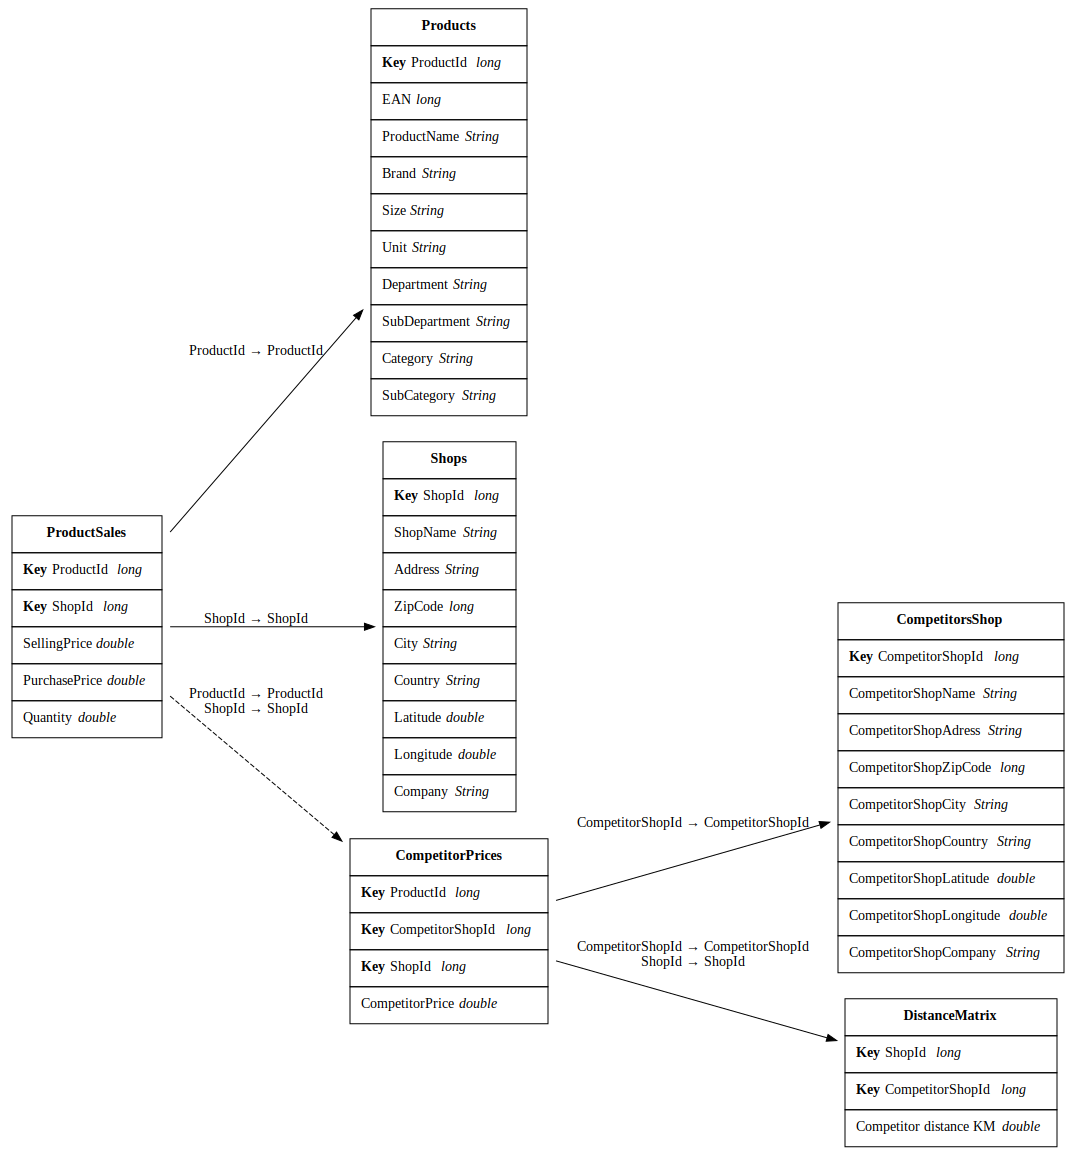

In [13]:
price_index_cube.schema

In [14]:
h = price_index_cube.hierarchies
m = price_index_cube.measures
lvl = price_index_cube.levels

In [15]:
m

Measures()

We can see a _SUM_ and _MEAN_ measure is created columns of type double/float for the base store - _ProductSales_.  
A _VALUE_ measure is created for columns of type double/float in the other referenced stores.  

With the cube created, let's start by computing the price index per shop.

### 1. Computing the price index per shop

There are different existing formulas for the price index. The formula we will use in this example compares a product price to the average price found among the local competitors of a particular shop, measuring at which percentage of this average competitors price the product is.

We will weight the price index indicator by the margin when aggregating above shop and product level. This is so that we can later optimize the price index for products that contribute the most to the margin. Other commonly used formulas weight by sales quantity or revenue.

#### Price index formula:

# $100 \times \frac{\sum_{s,p \in (Shops,Products)}\frac{Selling Price(s,p)}{Average Competitor Price(s,p)} \times Margin(s,p)}{\sum_{s,p \in (Shops,Products)}Margin(s,p)}$  

Let's create a measure to get the mean of _CompetitorPrice_ which will be used to derive the price index.

In [16]:
m["CompetitorPrice.MEAN"] = tt.agg.mean(m["CompetitorPrice.VALUE"])
m["CompetitorPrice.MEAN"].formatter = "DOUBLE[#,###.00]"

Instead of using Pandas to do pre-aggregation, we perform the margin computation with atoti so that we can see the change in its value after we optimise the selling price later on.

In [17]:
m["Margin.SUM"] = tt.agg.sum(
    (m["SellingPrice.SUM"] - m["PurchasePrice.SUM"]) * m["Quantity.SUM"],
    scope=tt.scope.origin(lvl["ProductId"], lvl["ShopId"]),
)

We see how the weight price index indicator can be achieved in the next few cells.  
Realize how we are setting the scope on _ProductId_ and _ShopId_? This will ensure the summation of the various measures at the _Shops_ and _Product_ level as required by the formula:

# ${\sum_{s,p \in (Shops,Products)}\frac{Selling Price(s,p)}{Average Competitor Price(s,p)} \times Margin(s,p)}$

In [18]:
price_index_numerator = tt.agg.sum(
    (m["SellingPrice.SUM"] * m["Margin.SUM"]) / m["CompetitorPrice.MEAN"],
    scope=tt.scope.origin(lvl["ProductId"], lvl["ShopId"]),
)

Finally, we calculate the contribution of the product towards the total margin.

In [19]:
m["Price Index"] = price_index_numerator / m["Margin.SUM"]

We can now have the price index per shop and product.  

atoti allows us to do [modeling with sampled size](https://docs.atoti.io/0.4.1/tutorial/02-Configuration.html#Sampling-mode) of the data.  
As we are currently in sampling mode, let's trigger full data load to do some visualizations.

In [20]:
session.load_all_data()

Let's visualize the price index per shop.

In [22]:
price_index_cube.visualize("Price index by shops")

Install and enable the atoti JupyterLab extension to see this widget.

### 2. Computing number of Competitors per Distance Bucket  

There are many ways to do compute the number of competitors per distance buckets. However, we are going to showcase how we can make use of the simulations to create the distance buckets. The advantage of doing so is that we can easily create new distance bucket with minimum coding.

Let's create a measure call `m["Distance Threshold"]` that contains the value for the distance threshold for each bucket and we start by looking at the number of competitors within 1km distance radius from our shop.

In [22]:
m["Distance Threshold"] = 1

Due to the join to the _CompetitorsPrice_ store, the `m["Contributor.COUNT]` returned is based on the products.  
We want to obtain the number of distinct competitors' shops that sell the same products as us, not the number of products.  

To do so, we look at the the average distance between the shop and its competitor, returning a count of 1 if it is located within our threshold radius.

In [23]:
m["Count within distance threshold"] = tt.agg.sum(
    tt.where(
        tt.agg.mean(m["Competitor distance KM.VALUE"]) < m["Distance Threshold"], 1, 0
    ),
    scope=tt.scope.origin(lvl["ShopId"], lvl["CompetitorShopId"]),
)

Naturally we can quickly use Pandas to derive the same value. However, when we use this one time setup together with simulations, we have the below benefits:
- easily add / delete the distance buckets
- ability to drill down on the data for each distance range to perform further analysis

#### Setting up simulation for distance buckets
We setup a simulation where we can replace the threshold value in order to be able to create scenarios for other ranges of distance.  
We name this base scenario "1km".

In [24]:
simulation = price_index_cube.setup_simulation(
    "Distance Simulation", base_scenario="01 km", replace=[m["Distance Threshold"]]
)

lvl["Distance Simulation"].comparator = tt.comparator.ASC

We can now easily obtain the number of competitors per area simply by creating a scenario for each distance radius.  
With this, we can easily create new distance buckets to generate different datasets for the machine learning.

In [25]:
simulation.scenarios["05 km"] = 5
simulation.scenarios["10 km"] = 10
simulation.scenarios["15 km"] = 15
simulation.scenarios["20 km"] = 20

Let's do a quick data-viz to see how the number of competitors varies by the distance.

In [27]:
price_index_cube.visualize("Nr of competitors by distance bucket")

Install and enable the atoti JupyterLab extension to see this widget.

In [28]:
m["CompetitorPrice.MEAN"] =  tt.agg.mean(
    tt.where(m["Competitor distance KM.VALUE"] < m["Distance Threshold"], m["CompetitorPrice.VALUE"], None)
)

In [30]:
price_index_cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

How do we systematically make use of this information?   
Let's use the _Competitors count within radius_ for each distance bucket and _PriceIndex_ computed above - to train a model and clusterize the stores.  
We can extract these data from atoti as shown in the function below:

In [31]:
def get_features():
    # output dataframe for competitors count per shop & area (distance radius) from cube querying
    shops_competitors_count_per_shop_area = price_index_cube.query(
        m["Count within distance threshold"],
        levels=[lvl["ShopId"], lvl["Distance Simulation"]],
    ).reset_index()

    # pivot the table such that each scenario becomes a column
    shops_competitors_count_per_shop_area = shops_competitors_count_per_shop_area.pivot(
        index="ShopId",
        columns="Distance Simulation",
        values="Count within distance threshold",
    )

    # output dataframe for price index by shop from cube querying
    price_index_per_shop_area = price_index_cube.query(
        m["Price Index"], levels=[lvl["ShopId"], lvl["Distance Simulation"]]
    ).reset_index()

    
    # pivot the table such that each scenario becomes a column
    price_index_per_shop_area = price_index_per_shop_area.pivot(
        index="ShopId",
        columns="Distance Simulation",
        values="Price Index",
    )
    
    # merge the 2 dataframe and return the output
    shops_features = pd.merge(
        shops_competitors_count_per_shop_area,
        price_index_per_shop_area,
        left_on="ShopId",
        right_on="ShopId",
        how="left",
    ).fillna(1)

    return shops_features

## 3. Machine Learning - Shops clustering using price index and competitors number features
We can use a machine algorithm such as k-means to make clusters with the features (01km, 05km, 10km, 15km, 20km, Price Index) that we obtained from the cube:

In [32]:
shops_features = get_features()
shops_features.head(15)

Distance Simulation,01 km_x,05 km_x,10 km_x,15 km_x,20 km_x,01 km_y,05 km_y,10 km_y,15 km_y,20 km_y
ShopId,,,,,,,,,,
1,11,51,66,71,71,0.971768,0.967427,0.979813,0.984359,0.984359
10,5,46,71,71,71,1.047618,0.998357,1.016020,1.016020,1.016020
11,3,3,3,3,3,0.931146,0.931146,0.931146,0.931146,0.931146
12,3,3,3,3,3,0.974644,0.974644,0.974644,0.974644,0.974644
13,2,2,2,2,2,1.094972,1.094972,1.094972,1.094972,1.094972
14,1,1,1,1,1,0.936847,0.936847,0.936847,0.936847,0.936847
15,1,1,1,1,1,0.974269,0.974269,0.974269,0.974269,0.974269
16,4,4,4,4,4,0.971294,0.971294,0.971294,0.971294,0.971294
17,1,1,1,1,1,1.001366,1.001366,1.001366,1.001366,1.001366


In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin

sns.set()  # for plot styling

Let's set the number of clusters needed as 5. The number of clusters can increase if the number of shops is huge.  
We apply the k-mean on the _shops\_feature_ from above.

In [34]:
number_of_clusters = 5
kmeans = MiniBatchKMeans(number_of_clusters)
kmeans.fit(shops_features)
new_colors = kmeans.cluster_centers_[kmeans.predict(shops_features)]
k_means_labels = pairwise_distances_argmin(shops_features, kmeans.cluster_centers_)
labels = KMeans(number_of_clusters, random_state=0).fit_predict(shops_features)

Using competitors within 1km as an example, we can now analyze the result of the clustering by pair of features using matplotlib as shown below:

Text(0, 0.5, 'Price Index')

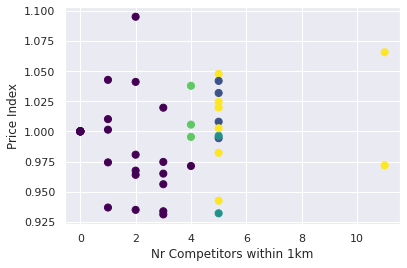

In [35]:
plt.scatter(
    shops_features.loc[:, "01 km_x"],
    shops_features.loc[:, "01 km_y"],
    c=k_means_labels,
    s=50,
    cmap="viridis",
)

plt.xlabel("Nr Competitors within 1km")
plt.ylabel("Price Index")

In the above plot, each color represents a cluster. We can see that clusters seem to be strongly based on the number of competitors rather than on the price index.  
However, to avoid having to plot every couple of features and understand more quickly what our clusters are, we will use seaborn to have a plot of the clustering result for every pair of features.

In [36]:
shops_features["Cluster"] = labels
shops_features.head(5)

Distance Simulation,01 km_x,05 km_x,10 km_x,15 km_x,20 km_x,01 km_y,05 km_y,10 km_y,15 km_y,20 km_y,Cluster
ShopId,,,,,,,,,,,
1,11,51,66,71,71,0.971768,0.967427,0.979813,0.984359,0.984359,1
10,5,46,71,71,71,1.047618,0.998357,1.016020,1.016020,1.016020,1
11,3,3,3,3,3,0.931146,0.931146,0.931146,0.931146,0.931146,0
12,3,3,3,3,3,0.974644,0.974644,0.974644,0.974644,0.974644,0
13,2,2,2,2,2,1.094972,1.094972,1.094972,1.094972,1.094972,0


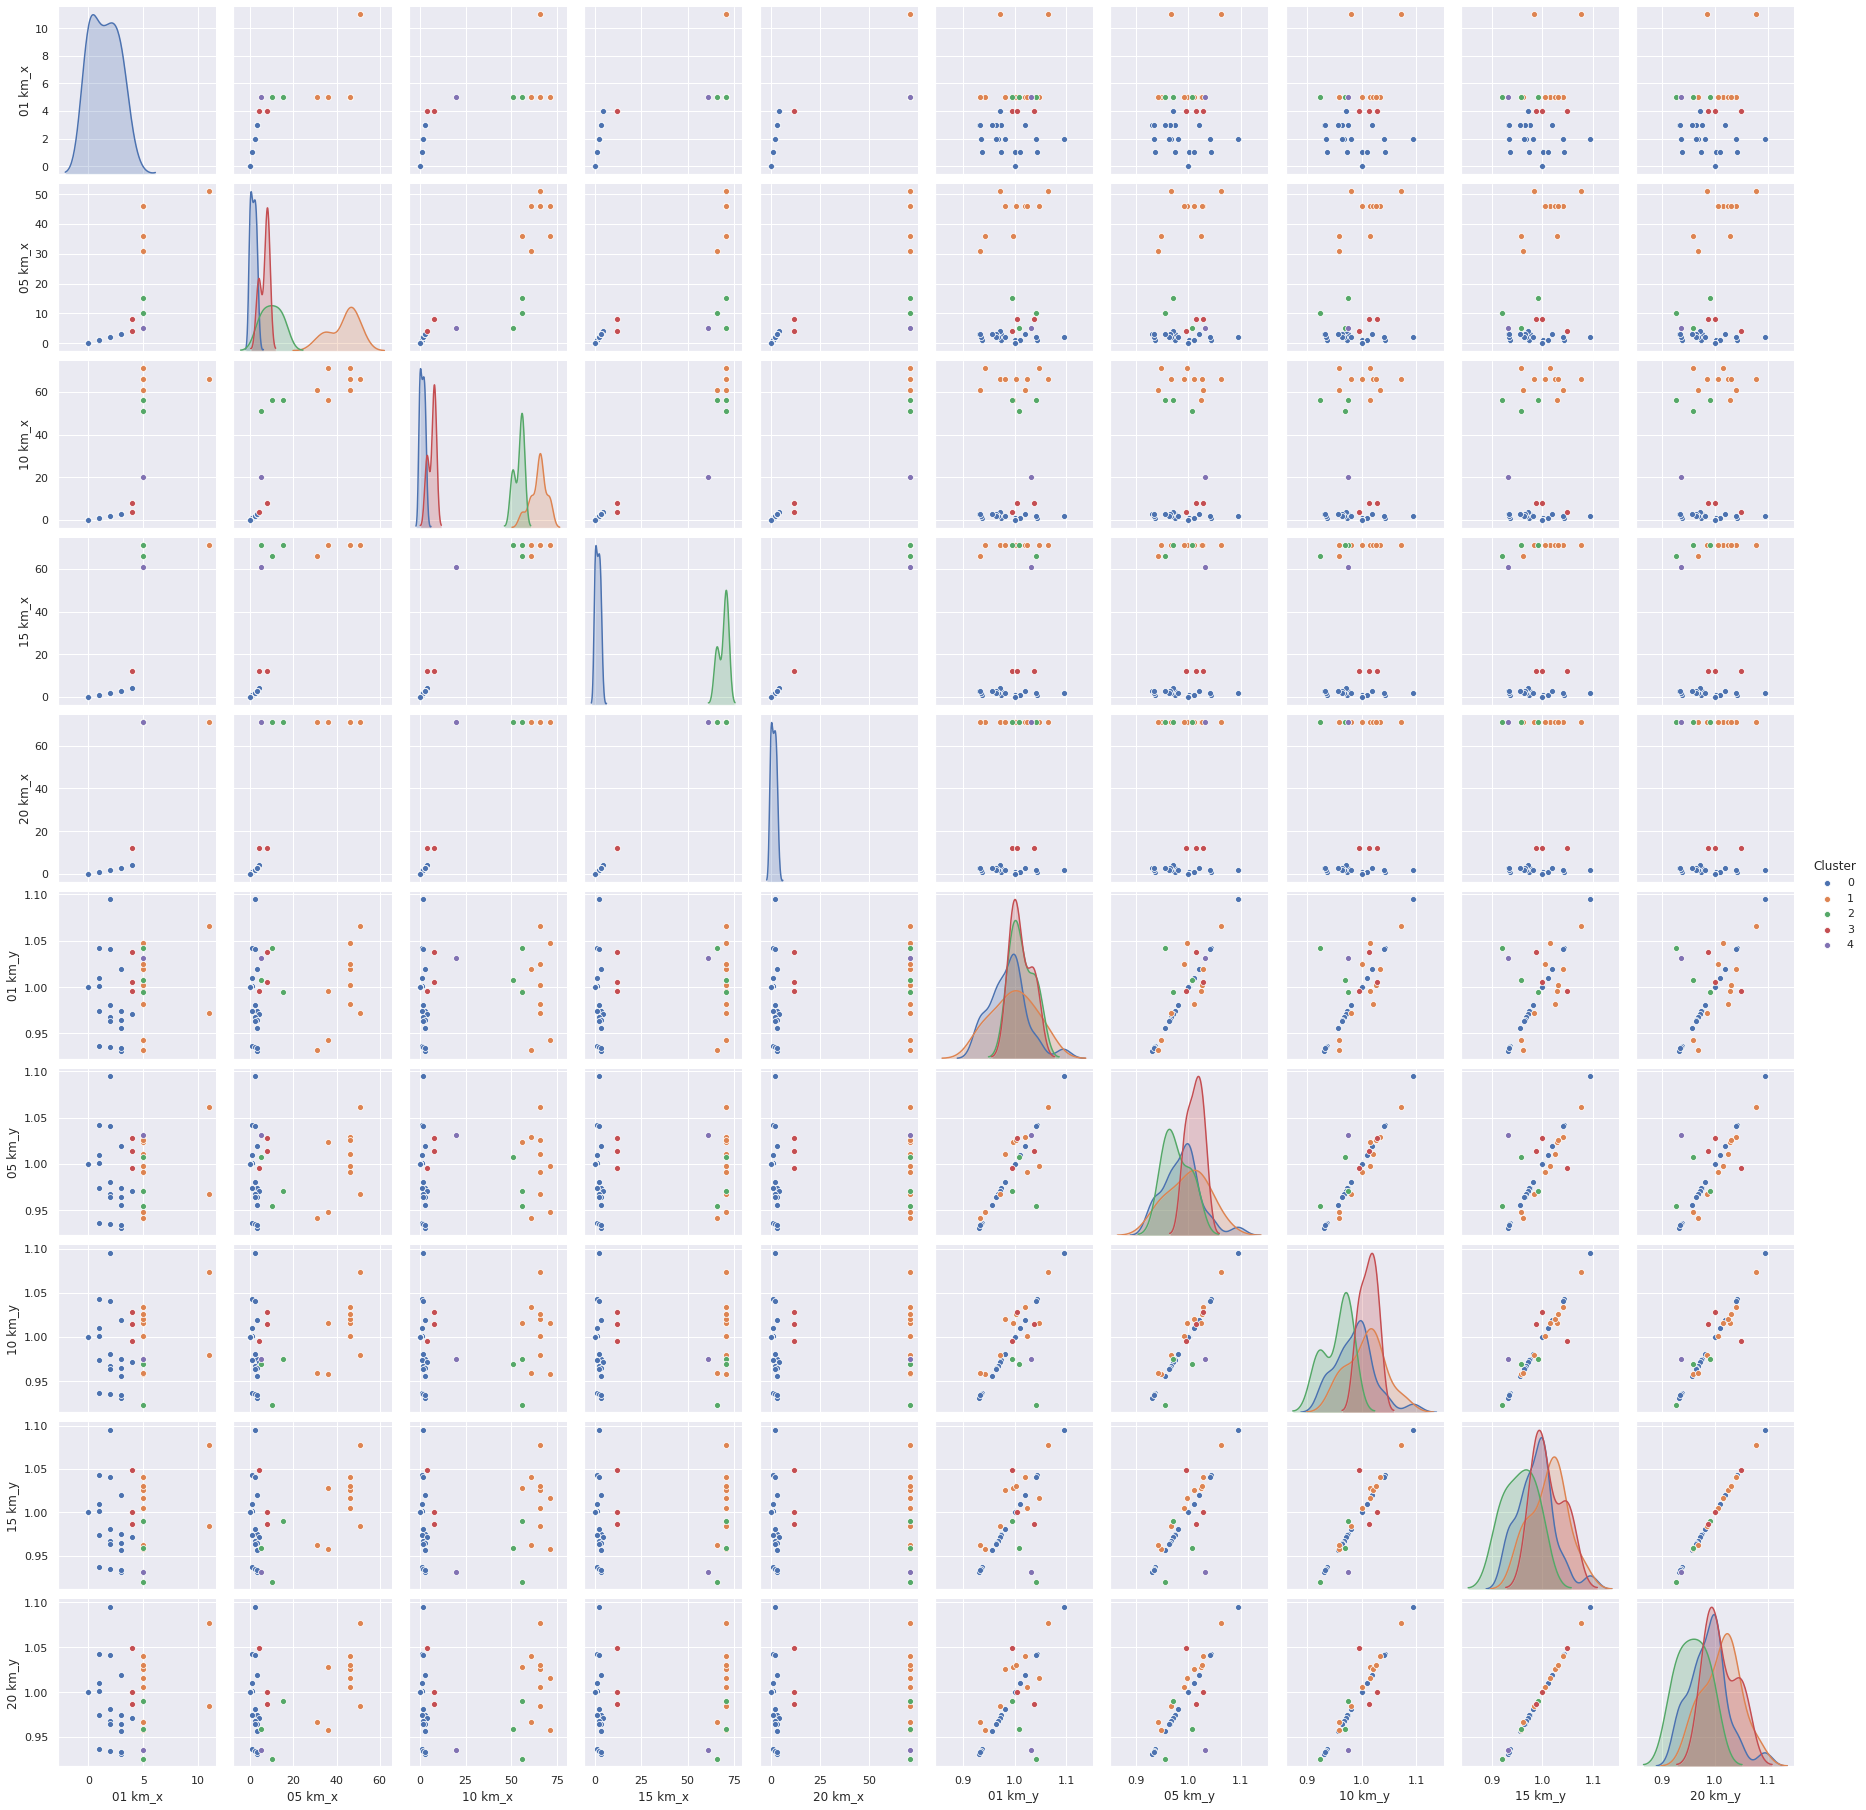

In [37]:
sns.pairplot(data=shops_features, hue="Cluster")

We can have a better understanding of the clusters with the chart above.  
The stores in cluster 1 have a much higher number of competitors (>50) in a 10km radius, compared to those of cluster 0 having less than 20 competitors in the same radius.  
While cluster 1 has more competitors, its price index is generally higher than cluster 0 and greater than 1.

Continuing this analysis tells us that:
- Cluster 0 is a big cluster with little competitors around.
- Cluster 1 is slightly skewed towards a higher price index than the rest while the number of competitors are generally higher even within a 5km distance radius.
- Cluster 2 is a small cluster and the number of competitors increases tremendously as the distance radius increases.
- Cluster 3 has a relatively lower price index even though some of the shops has price index closer to 1. Number of competitors remains about the same across all buckets.
- Cluster 4 is a small cluster that has a slightly lower price index and most competitors are more than 10km away.

While this gives us an idea of how to position ourselves, we need to put these into context before we can decide on what pricing strategy to apply on it.  
Let's load the new cluster back into the cube to have more in-depth analysis.

## 4. Interpreting the machine learning output with atoti

Let's load the cluster results obtained from the machine learning model into the cube.

In [38]:
clusters_df = shops_features[["Cluster"]].reset_index()
clusters_df.ShopId = clusters_df.ShopId.astype("int32")
clusters = session.read_pandas(clusters_df, keys=["ShopId"], store_name="Clusters")

clusters.head(5)

,Cluster
ShopId,
1,1
10,1
11,0
12,0
13,0


In [39]:
shops.join(clusters)

Let's see the spread of the clusters on the map.

In [41]:
price_index_cube.visualize("Spread of clusters on map")

Install and enable the atoti JupyterLab extension to see this widget.

Interestingly, cluster 0 is distributed all over France except Paris, and mostly they are the only shop in the neighbourhood that is under our retailer.   
Cluster 3 is a small cluster around Lille, the capital of the Hauts-de-France region in northern France.  
The rest of the clusters have shops under our retailer in close proximity, and most of them spread around Paris.
The size of the points on the map reflects the number of competitors within 5km - we can see the competition around the city is the highest, specifically for cluster 1 (red).

In the case of cluster 0, the shop is the only one under the retailer in the neighbourhood. The number of competitors is low, hence the price index is less affected by competition.  
Rather, other factors such as variety of products, branding etc could take on a heavier factor on the price index - these are to be considered when applying a pricing strategy for this cluster. Generally, the price index could be higher.  

For the rest of the clusters, there are a few considerations. Within the same proximity, the shops face the same competitors.  
Not only that, consumers can easily detect the price differences of products between the shops of the same retailer if they are close to one another.  
Hence it makes more sense to align their price index and it should be slightly lower to push up its competitiveness.

## 5. Pricing simulations around clusters

We will now generate new prices using the clustering information in order to take into account the different competitiveness constraints of the shops.  

Using the clusters generated, the below pricing method tries to reduce the prices if the competitiveness is strong, and on the contrary increase it if there is few competition.  
For instance, cluster 0 and cluster 4 has little competition, hence their price index could be slightly higher than 1.  
The rest of the clusters have more competitors within 10km radius, hence could have their price index at 1 or slightly lower to maintain their competitivity.  

In [42]:
from utils import pricer

selling_prices_based_on_clusters = pricer.optimize_prices(product_sales_df, clusters_df)

Thanks to atoti built-in simulations capabilities, we can easily create a new scenario for the new pricing by directly loading the price-optimised dataframe.  
All the previously defined KPIs, e.g. the price index, will be re-computed on the fly, enabling us to compare the scenarios and their benefits.

In [43]:
productSales.scenarios["Selling prices based on clusters"].load_pandas(
    selling_prices_based_on_clusters
)

Thanks to atoti built-in simulations capabilities, we can easily create a new scenario for the new pricing by directly loading the price-optimised dataframe.  
All the previously defined KPIs, e.g. the price index and margin, will be re-computed on the fly, enabling us to compare the scenarios and their benefits.  

Although it may seem like we are earning less margin for cluster 1 after price optimisation, we should have an increase in quantity sold if the strategy works well.  
Not only has the overall margin increased for the other clusters, increase in sales for cluster 1 should also contribute to the increase subsequently.

In [45]:
price_index_cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

We saw the adjustment in price index at the cluster level and we could easily drill down to the shop and even product level.  
Now, let's visualize the changes in price index for the 5 clusters.

In [47]:
price_index_cube.visualize("Price index optimisation difference")

Install and enable the atoti JupyterLab extension to see this widget.

In order to attract more customers, we can see that the pricing method decreased the pricing for cluster 1, which faced high competitions.  
On the contrary it increased the prices in shops belonging to low competition clusters in order to maximize margin.  
Cluster 0, 3 and 4 for instance, have very few competitors. Hence their selling prices are adjusted higher, resulting in higher price index.

## 6. Selling price simulation by clusters and shops

Zooming in on cluster 1, we see that _MyShop Paris 6_ has one of the highest competition within the cluster.  
<img src="https://data.atoti.io/notebooks/geopricing/cluster1.png" alt="Clustering 1" style="width:600px;"/>

However, the store also has a relatively high price index within the cluster.

In [49]:
price_index_cube.visualize("Price index for cluster 1")

Install and enable the atoti JupyterLab extension to see this widget.

Let's scale down the price index of the shop using atoti's measure simulation.

In [50]:
price_simulation = price_index_cube.setup_simulation(
    "Price simulation",
    base_scenario="Selling Price Initial",
    levels=[lvl["ShopId"]],
    multiply=[m["SellingPrice.MEAN"]],
)

We are now able to scale the _Selling Price_ either across clusters or by specific shop.

In [51]:
cluster_adjustment = price_simulation.scenarios["Selling Price New"]
cluster_adjustment.append((7, 0.90),)

In [53]:
price_index_cube.visualize("Price index optimisation difference by scenario")

Install and enable the atoti JupyterLab extension to see this widget.

The price index after price optimization and the shop adjustment for the shop looks more aligned now. 

Using a very simple machine learning example, we saw how it could help to identify the clusters based on the amount of geographical competitions.  
With this information, we applied different pricing strategies to each cluster using simulations from atoti to understand the impact on the price index.
We also look within a cluster to adjust the pricing of a specific shop so that it's more attuned to the pricing of the other shops in the cluster. 

We saw that despite the small amount of data that we have, we could already come up with a decent pricing strategy with atoti.  
If we have more data such as the quantity of products sold, we can easily see the differences in the margin with each pricing strategy, with the possibility to drill down to various valuable attributes.  
We can thereafter decide on the best pricing from the combination of simulations. Not to mention that with atoti, we can easily combine the simulations of various factors such as festivals, promotions, seasons etc.

Do have a look at how we can strategize the price index around product class in the [pricing-simulations-around-product-classes](https://github.com/atoti/notebooks/tree/master/retail/pricing-simulations-around-product-classes) notebook and its [corresponding article](https://www.atoti.io/data-dive-how-to-improve-pricing-strategies-with-a-set-of-checkout-receipts/).  
Maybe you can have a go at combining the two strategies to get your own price index!